In [2]:
#backward difference encoder
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from yellowbrick.regressor import residuals_plot, prediction_error
from fast_ml.model_development import train_valid_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from tpot import TPOTRegressor
import category_encoders as ce
import time
from xgboost import XGBRegressor
from scipy import stats
import warnings
encoders = {

    'BackwardDifferenceEncoder': ce.backward_difference.BackwardDifferenceEncoder,
    'OneHotEncoder': ce.one_hot.OneHotEncoder,
    
}


# PREPROC

In [3]:
pop_df = pd.read_csv('./Participants_dataset/population.csv')
roads_df = pd.read_csv('./Participants_dataset/roads_network.csv')
train_df = pd.read_csv('./Participants_dataset/train.csv')

In [4]:
test_df = pd.read_csv('./Participants_dataset/test.csv')

<AxesSubplot:>

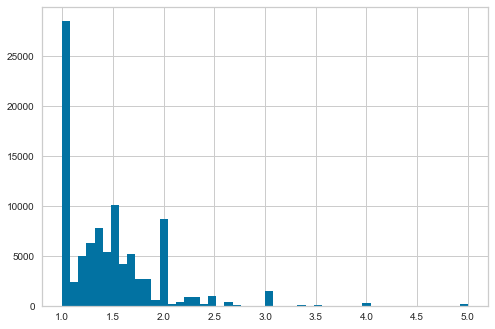

In [5]:
# target
grouped = train_df.groupby('postcode',sort='False',as_index=False)
# train_enriched_df = train_enriched_df.drop(['Number_of_Casualties','Accident_ID'])

Accident_Risk_Index_df = grouped.apply(lambda grp: sum(grp.Number_of_Casualties) / len(grp.Accident_ID))
Accident_Risk_Index_df.columns = ['postcode','Accident_Risk_Index']
Accident_Risk_Index_df.Accident_Risk_Index.hist(bins=50)

In [6]:
train_df.shape

(478741, 27)

In [7]:
Accident_Risk_Index_df.shape

(95625, 2)

In [8]:
roads_numeric_features = roads_df.select_dtypes([np.number]).columns
roads_categorical_features = roads_df.select_dtypes(exclude=[np.number]).drop(['WKT','postcode'],axis=1).columns
# overwrite roads df for mem
roads_df = pd.concat([pd.get_dummies(roads_df[roads_categorical_features]),roads_df.drop(roads_categorical_features,axis=1)],axis=1)

In [9]:
roads_features_df = pd.concat([roads_df.drop('WKT',axis=1).groupby('postcode').agg(sum),roads_df.drop('WKT',axis=1).groupby('postcode').agg(np.nanmean)],axis=1)
roads_features_df.columns = [x+'_sum' if i >= 12 else x+'_mean' for i,x in enumerate(roads_features_df.columns)]

In [10]:
pop_df = pop_df.drop(['Rural Urban'],axis=1)


In [11]:
train_df = train_df.drop('country',axis=1)
test_df = test_df.drop('country',axis=1)

In [12]:
train_roads_df = train_df.set_index('postcode').join(roads_features_df, how= 'left')
test_roads_df = test_df.set_index('postcode').join(roads_features_df, how= 'left')

In [13]:
print((~train_roads_df.roadClassi_Motorway_mean.isnull()).sum())
inds_where_null = np.where(train_roads_df.roadFuncti_Motorway_sum.isnull())
inds_where_not_null = np.where(train_roads_df.roadFuncti_Motorway_sum.notnull())
# inds where null fill with post town

inds_where_null_test = np.where(test_roads_df.roadFuncti_Motorway_sum.isnull())
inds_where_not_null_test = np.where(test_roads_df.roadFuncti_Motorway_sum.notnull())


28752


In [14]:
roads_features_df['post_town'] = list(pd.Series(roads_features_df.index).str.upper().apply(lambda row_str: row_str.split(' ')[0]))

In [15]:
roads_town_df = roads_features_df.groupby('post_town').agg(np.nanmean)

In [16]:
train_df['post_town'] = train_df.postcode.apply(lambda row_str: row_str.split(' ')[0])
post_code_level_df = train_df.iloc[inds_where_null].set_index('post_town').join(roads_town_df, how='left')
post_town_level_df = train_roads_df.iloc[inds_where_not_null]
train_enriched_df = pd.concat([post_code_level_df, post_town_level_df],axis=0)

test_df['post_town'] = test_df.postcode.apply(lambda row_str: row_str.split(' ')[0])
post_code_level_df_test = test_df.iloc[inds_where_null_test].set_index('post_town').join(roads_town_df, how='left')
post_town_level_df_test = test_roads_df.iloc[inds_where_not_null_test]
test_enriched_df = pd.concat([post_code_level_df_test, post_town_level_df_test],axis=0)


In [17]:
pop_df['post_town'] = pop_df.postcode.apply(lambda row_str: row_str.split(' ')[0])  


In [18]:
len(set(pop_df.post_town)) #I'm not sure post_town is worth adding 

2269

In [19]:
'''train_enriched_df = train_enriched_df.set_index('post_town').join(pop_df.groupby('post_town',sort=False, as_index=False).agg(np.nanmean),how='left').reset_index()
test_enriched_df = test_enriched_df.set_index('post_town').join(pop_df.groupby('post_town',sort=False, as_index=False).agg(np.nanmean),how='left').reset_index()


train_enriched_df = train_enriched_df.rename({'index':'post_town'},axis=1)
test_enriched_df = test_enriched_df.rename({'index':'post_town'},axis=1)'''

"train_enriched_df = train_enriched_df.set_index('post_town').join(pop_df.groupby('post_town',sort=False, as_index=False).agg(np.nanmean),how='left').reset_index()\ntest_enriched_df = test_enriched_df.set_index('post_town').join(pop_df.groupby('post_town',sort=False, as_index=False).agg(np.nanmean),how='left').reset_index()\n\n\ntrain_enriched_df = train_enriched_df.rename({'index':'post_town'},axis=1)\ntest_enriched_df = test_enriched_df.rename({'index':'post_town'},axis=1)"

In [20]:
#train_enriched_df = train_enriched_df.drop(['post_town', 'postcode'],axis=1)
#test_enriched_df = test_enriched_df.drop([ 'postcode'],axis=1)
#keep posttown and postcode features

In [21]:
train_enriched_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478741 entries, AB10 to ZE2 9JJ
Data columns (total 50 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_ID                                  478741 non-null  int64  
 1   Police_Force                                 478741 non-null  int64  
 2   Number_of_Vehicles                           478741 non-null  int64  
 3   Number_of_Casualties                         478741 non-null  int64  
 4   Date                                         478741 non-null  object 
 5   Day_of_Week                                  478741 non-null  int64  
 6   Time                                         478726 non-null  object 
 7   Local_Authority_(District)                   478741 non-null  int64  
 8   Local_Authority_(Highway)                    478741 non-null  object 
 9   1st_Road_Class                               478741 non-null

In [22]:
train_enriched_df=train_enriched_df.drop(['Accident_ID'],axis=1)
test_enriched_df=test_enriched_df.drop(['Accident_ID'],axis=1)

In [23]:
train_enriched_df.isnull().sum()

Police_Force                                       0
Number_of_Vehicles                                 0
Number_of_Casualties                               0
Date                                               0
Day_of_Week                                        0
Time                                              15
Local_Authority_(District)                         0
Local_Authority_(Highway)                          0
1st_Road_Class                                     0
1st_Road_Number                                    0
Road_Type                                          0
Speed_limit                                        0
2nd_Road_Class                                     0
2nd_Road_Number                                    0
Pedestrian_Crossing-Human_Control                  0
Pedestrian_Crossing-Physical_Facilities            0
Light_Conditions                                   0
Weather_Conditions                                 0
Road_Surface_Conditions                       

In [24]:
train_postcode = train_enriched_df['postcode']
test_postcode = test_enriched_df['postcode']
train_enriched_df = train_enriched_df.drop(['postcode'],axis=1)
test_enriched_df = test_enriched_df.drop(['postcode'],axis=1)

In [492]:
'''mean_fill = train_enriched_df.iloc[:,-8:].columns
mode_fill = train_enriched_df.iloc[:,:-8].columns
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy='most_frequent')
train_enriched_df[mode_fill] = mode_imputer.fit_transform(train_enriched_df[mode_fill])
mean_imputer = SimpleImputer(strategy='mean')
train_enriched_df[mean_fill] = mean_imputer.fit_transform(train_enriched_df[mean_fill])

test_enriched_df[mode_fill] = mode_imputer.transform(test_enriched_df[mode_fill])
test_enriched_df[mean_fill] = mean_imputer.transform(test_enriched_df[mean_fill])'''

ValueError: Columns must be same length as key

In [25]:
train_enriched_df['month_of_year'] = pd.to_datetime(train_enriched_df.Date).dt.month
train_enriched_df['day_of_month'] = pd.to_datetime(train_enriched_df.Date).dt.day
train_enriched_df = train_enriched_df.drop(['Date'],axis=1)

test_enriched_df['month_of_year'] = pd.to_datetime(test_enriched_df.Date).dt.month
test_enriched_df['day_of_month'] = pd.to_datetime(test_enriched_df.Date).dt.day
test_enriched_df = test_enriched_df.drop(['Date'],axis=1)

In [26]:
train_enriched_df['Time'] = train_enriched_df.Time.fillna('0').astype(str).apply(lambda row: row.replace(':','') ).astype(int)
test_enriched_df['Time'] = test_enriched_df.Time.fillna('0').astype(str).apply(lambda row: row.replace(':','')).astype(int)

In [27]:
cat_cols = []
num_cols = list(train_enriched_df.select_dtypes([np.number]).columns)
for col in train_enriched_df.select_dtypes(exclude=[np.number]).columns:
    if (~train_enriched_df[col].astype(str).apply(lambda row: row.replace('.','').replace('-','').isdigit())).sum() != 0:
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [28]:
cat_cols

['Local_Authority_(Highway)',
 'Road_Type',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'state']

In [ ]:
'''num_cols.append('distance to the nearest point on rd_mean') 
cat_cols.pop(-1)
# remove postcode
del cat_cols[-1]
 '''

In [ ]:
# postcodes.Accident_Risk_Index (mean casualties at a postcode) = sum(Number_of_casualities)/count(Accident_ID)


In [29]:
train_enriched_df=train_enriched_df.reset_index().rename({'index':'post_town'},axis=1)
test_enriched_df=test_enriched_df.reset_index().rename({'index':'post_town'},axis=1)

# MODEL

In [30]:
import os 
current_dir = os.getcwd()
os.chdir('..')
from Utils.Metrics import regression as reg_metrics
os.chdir(current_dir)

In [31]:
results_df = pd.DataFrame(columns = ['model','rmse','r2','mape'])

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin


numeric_features = num_cols

categorical_features = cat_cols

max_levels = round(train_enriched_df.columns.shape[0]*0.1)
cats_many = []
cats_few = []
for ft in categorical_features:
    levels = train_enriched_df[ft].unique().shape[0]
    if levels > max_levels:
        cats_many.append(ft)
    else:
        cats_few.append(ft)
        
class group_data_by_postcode(BaseEstimator, TransformerMixin):
    #def __init__(self, post_group):
    #    self.post_group = post_group
    def __init__(self, post_group):
        self.post_group = post_group    
    def fit(self, X, y=None):
        self.groups = groups
        return self
    
    def transform(self, X, y=None):        
        groups = self.groups
        X1 = groups.agg(np.nanmean)
        X2 = groups.agg(np.sum)
        X4 = groups.agg(stats.mode)
        return pd.concat([X1,X2,X3],axis=1)
        
        

X = train_enriched_df
y = Accident_Risk_Index_df.Accident_Risk_Index

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

selected_model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)


categorical_transformer_many_level = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['BackwardDifferenceEncoder']())
    ]
)    

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['OneHotEncoder']())
    ]
) 

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

aggregator = Pipeline(steps=[('groupby_postcode',group_data_by_postcode(train_postcode))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical_many', categorical_transformer_many_level, cats_many),
        ('categorical', categorical_transformer, cats_few)
    ]
)



In [34]:
train_enriched_df[cats_many].apply(set).apply(len)

Local_Authority_(Highway)                  207
Road_Type                                    6
Pedestrian_Crossing-Physical_Facilities      6
Weather_Conditions                           9
Road_Surface_Conditions                      6
Special_Conditions_at_Site                   9
Carriageway_Hazards                          6
dtype: int64

In [35]:
len(set(train_postcode.values).intersection(test_postcode)), len(set(test_postcode))

(44079, 48350)

In [36]:
train_postcode=np.where(train_postcode.isnull(),train_postcode.index,train_postcode)
test_postcode=np.where(test_postcode.isnull(),test_postcode.index,test_postcode)

In [37]:
X_prc = preprocessor.fit_transform(X)
X_prc = pd.DataFrame(X_prc)

In [89]:
X_test_prc = preprocessor.transform(test_enriched_df)
X_test_prc = pd.DataFrame(X_test_prc)

In [90]:
import gc
gc.collect()

139

In [40]:
X_prc.shape

(478741, 294)

In [127]:
# groupby on strings just way too slow
def groupby_postcode(X, grouper_var, postcode_to_ind_dct):       
        postcode_to_ind_dct = {x:i for i,x in enumerate(grouper_var)}
        #grouper_var = pd.Series(train_postcode).replace(postcode_to_ind_dct).values
        grouper_var = pd.Series(grouper_var).map(lambda x: postcode_to_ind_dct[x])
        groups = X.groupby(grouper_var,sort='False',as_index=True)
        print('groups created')
        X1 = groups.agg(np.nanmean)
        print('mean grouped')
        X2 = groups.agg(np.sum)
        print('sum grouped')
        X3 = groups.agg('first')
        print('first grouped')
        ind_to_postcode={v:k for k,v in postcode_to_ind_dct.items()}
        return pd.concat([X1,X2,X3],axis=1), [ind_to_postcode[x] for x in X1.index]
#postcode_to_ind_dct = {i:x for i,x in enumerate(train_postcode)}
X_prc_grp = groupby_postcode(X_prc,list(train_df.postcode), postcode_to_ind_dct)

In [128]:
X_test_prc_grp, inds = groupby_postcode(X_test_prc,list(test_df.postcode), postcode_to_ind_dct)

groups created
mean grouped
sum grouped
first grouped


In [130]:
len(set(inds))

49772

In [92]:
#postcode_to_ind_dct={v:k for (k, v) in postcode_to_ind_dct.items()}
X_prc_grp.shape, X_test_prc_grp.shape

((95625, 882), (49772, 882))

In [66]:

X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X_prc_grp, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test_tmp, y_test_tmp, test_size=0.5)
del X_test_tmp, y_test_tmp


In [67]:
evalset = [(X_train, y_train), (X_val,y_val)]

In [75]:
len(X_train.columns),len(set(X_train.columns))
#X_train.columns = list(range(len(X_train.columns)))
#X_val.columns = list(range(len(X_val.columns)))

In [76]:
# BASIC TUNE PARAMS 

start_time=time.time()

# grid search
xgb_reg = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)

param_grid = {
        'max_depth': [6, 9, 12],
        'learning_rate': [0.03, 0.05, 0.07],
        'n_estimators':[1500, 1800, 2100],
                               }

kfold = KFold(n_splits=5, shuffle=True, random_state=10)
grid_search = GridSearchCV(xgb_reg, param_grid, scoring="neg_root_mean_squared_error", cv=kfold)
grid_result = grid_search.fit(X_train, y_train, verbose=0, eval_set=evalset)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

print(time.time()-start_time)

Best: -1.015334 using {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 1500}
48602.561182022095


In [77]:
model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **grid_result.best_params_)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

<AxesSubplot:>

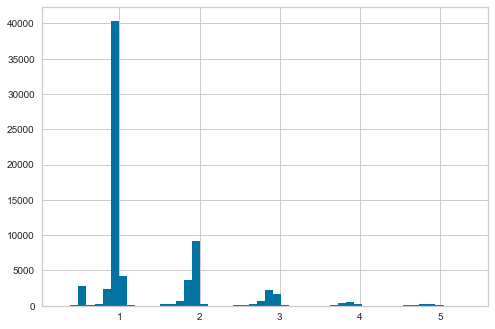

In [151]:
pd.Series(np.exp(y_pred)).hist(bins=50)

In [79]:
pred = y_scaler.inverse_transform(y_pred.reshape(-1,1))
y_val_s = y_scaler.inverse_transform(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'GridSearchCV XGBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

,model,rmse,r2,mape
0,GridSearchCV XGBReg,0.486658,-37.669473,24.491357


In [80]:
grid_result.best_params_ #{'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 1500}

{'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 1500}

# TEST

In [82]:
full_X_arr = np.vstack((X_train,X_val,X_test))
full_y_arr = np.vstack((y_train, y_val, y_test)) #hstack since one dim

In [83]:
#train on full dataset
model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **grid_result.best_params_)
model.fit(full_X_arr,full_y_arr)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, single_precision_histogram=True,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [ ]:
# do not forget to exp predictions

In [93]:
test_preds = model.predict(X_test_prc_grp)

array([[1.4150889],
       [1.4029067],
       [1.3952264],
       ...,
       [1.4027836],
       [1.6254194],
       [1.5548173]], dtype=float32)

In [131]:
res_df=pd.DataFrame(inds)

In [132]:
res_df['Accident_Risk_Index'] = y_scaler.inverse_transform( test_preds.reshape(-1,1))

In [135]:
res_df = res_df.rename({0:'postcode'},axis=1)

In [136]:
res_df.to_csv('preds_1.csv')

In [85]:
os.getcwd()

'D:\\Projects\\FailSafe_500\\12. Accident Risk'

In [88]:
test_df[['postcode','Accident_risk_index']].to_pickle('s1')  #to_csv(index=False) #to_csv('.//s1.csv')

In [81]:
pd.read_csv('./Participants_dataset/sample_submission.csv').sample(2)

,postcode,Accident_risk_index
22065,LE2 5WP,0
8548,CV32 6RW,0


In [104]:
pd.read_csv('./Participants_dataset/test.csv').shape

(121259, 27)

In [107]:
test_df.postcode.unique().shape

(49772,)

In [82]:
test_df.to_csv('test_df')

ImportError: cannot import name 'FilePath' from 'pandas._typing' (C:\Users\nikig\anaconda3\envs\AutoML\lib\site-packages\pandas\_typing.py)

In [93]:
import pickle 
pd.read_pickle('s1')

,postcode,Accident_risk_index
0,HX2 8WH,0.980894
1,RM8 1DD,0.950313
2,SE23 1NH,0.974750
3,HU10 7QS,0.951135
4,BD23 5JL,0.923324
...,...,...
121254,HD9 4AB,0.898282
121255,AL2 1FS,0.792765
121256,BN3 3WA,0.794601
121257,DL14 8HH,0.653029


In [159]:
#ar=
#test_df[['postcode','Accident_risk_index']].groupby('postcode').agg(np.nanmean)

ar=pd.concat([pd.Series(test_preds),test_df['postcode']],axis=1).groupby('postcode',sort=False).agg(np.max).apply(np.abs).reset_index()

<AxesSubplot:>

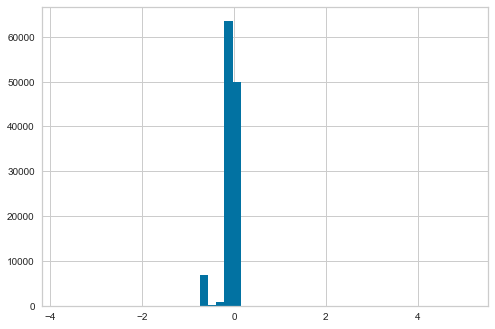

In [148]:
pd.Series(test_preds).hist(bins=50)

<AxesSubplot:>

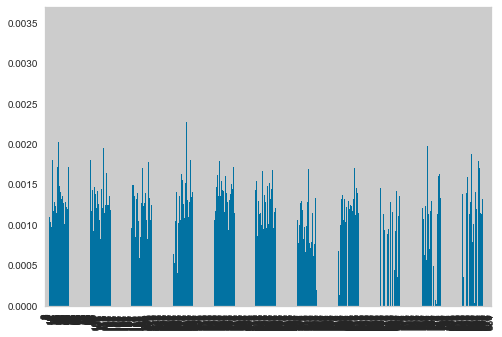

In [138]:
pd.Series(model.feature_importances_).plot(kind='bar')

In [158]:
cats_many

['Local_Authority_(Highway)',
 'Road_Type',
 'Pedestrian_Crossing-Physical_Facilities',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards']

In [156]:
preprocessor.named_transformers_['categorical_many'][1].get_feature_names()

['intercept',
 '0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '0_5',
 '0_6',
 '0_7',
 '0_8',
 '0_9',
 '0_10',
 '0_11',
 '0_12',
 '0_13',
 '0_14',
 '0_15',
 '0_16',
 '0_17',
 '0_18',
 '0_19',
 '0_20',
 '0_21',
 '0_22',
 '0_23',
 '0_24',
 '0_25',
 '0_26',
 '0_27',
 '0_28',
 '0_29',
 '0_30',
 '0_31',
 '0_32',
 '0_33',
 '0_34',
 '0_35',
 '0_36',
 '0_37',
 '0_38',
 '0_39',
 '0_40',
 '0_41',
 '0_42',
 '0_43',
 '0_44',
 '0_45',
 '0_46',
 '0_47',
 '0_48',
 '0_49',
 '0_50',
 '0_51',
 '0_52',
 '0_53',
 '0_54',
 '0_55',
 '0_56',
 '0_57',
 '0_58',
 '0_59',
 '0_60',
 '0_61',
 '0_62',
 '0_63',
 '0_64',
 '0_65',
 '0_66',
 '0_67',
 '0_68',
 '0_69',
 '0_70',
 '0_71',
 '0_72',
 '0_73',
 '0_74',
 '0_75',
 '0_76',
 '0_77',
 '0_78',
 '0_79',
 '0_80',
 '0_81',
 '0_82',
 '0_83',
 '0_84',
 '0_85',
 '0_86',
 '0_87',
 '0_88',
 '0_89',
 '0_90',
 '0_91',
 '0_92',
 '0_93',
 '0_94',
 '0_95',
 '0_96',
 '0_97',
 '0_98',
 '0_99',
 '0_100',
 '0_101',
 '0_102',
 '0_103',
 '0_104',
 '0_105',
 '0_106',
 '0_107',
 '0_108',
 '0_10

In [154]:
be=ce.BackwardDifferenceEncoder()
be.